# Library

In [46]:
import pandas as pd
import numpy as np
import PreProcessingText as ppt
from collections import Counter, defaultdict
import seaborn as sns
from wordcloud import WordCloud
import networkx as nx
import matplotlib.pyplot as plt
import squarify
from transformers import pipeline
from tqdm import tqdm
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from bertopic.representation import MaximalMarginalRelevance, KeyBERTInspired
from sklearn.feature_extraction.text import CountVectorizer
from keybert import KeyBERT
from umap import UMAP
import hdbscan
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import csv
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.cluster import KMeans
from scipy.spatial import distance
from scipy.cluster import hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

## 4° Approach: BERTopic

In [2]:
df = pd.read_csv('cleaned_data_name_thread.csv')
df = df.dropna(subset=['name_thread'])
df = df.drop_duplicates(subset=['name_thread'], keep='first')
df.shape[0]

66735

In [3]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
tc1 = ppt.TextClustering(df, 'name_thread')
tc1.encode_corpus(model, batch_size=64, to_tensor=False)

2024-06-25 18:13:12,124 - PreProcessingText - INFO - Encoding the corpus. This might take a while.
Batches: 100%|██████████| 1024/1024 [49:10<00:00,  2.88s/it]


array([[-0.05596191, -0.02048208, -0.0408654 , ...,  0.08593359,
         0.00841053,  0.050496  ],
       [ 0.04792455,  0.03172958, -0.00972225, ...,  0.08062411,
        -0.01151249,  0.01218798],
       [ 0.03451192, -0.00469939, -0.02061377, ..., -0.00406794,
        -0.05484711,  0.01487001],
       ...,
       [-0.02473538,  0.03251029, -0.04452128, ...,  0.00017893,
        -0.03766498,  0.03074655],
       [ 0.01396964,  0.01344143,  0.00063247, ..., -0.04474387,
        -0.02578878,  0.03929782],
       [ 0.06482894,  0.03406253, -0.07691094, ...,  0.02101658,
         0.01186585, -0.04680967]], dtype=float32)

In [5]:
len(tc1.corpus), len(tc1.corpus_embeddings)

(65529, 65529)

In [112]:
seed_topic_list = [[
    'tor site', 'drug', 'cocaine', 'ketamine', 'weed', 'trafficking', 'scammer', 'market', 'vendor', 'bitcoin',
    'mdma', 'coke', 'lsd', 'heroine', 'xanax', 'tor node', 'tor site', 'gun', 'weapon', 'hacking'
]]

zeroshot_topic_list = [pd.read_csv('../../../intent_crime.csv')['intent'].tolist()]

representation_model = MaximalMarginalRelevance(diversity=0.3)
vectorizer_model = CountVectorizer(stop_words="english")
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=1200, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

topic_model = BERTopic(
    language='multilingual',
    top_n_words=10, 
    n_gram_range=(1, 2),
    umap_model=umap_model, 
    hdbscan_model=hdbscan_model, 
    seed_topic_list=seed_topic_list, 
    vectorizer_model=vectorizer_model, 
    ctfidf_model=ctfidf_model, 
    representation_model=representation_model,
    zeroshot_topic_list=zeroshot_topic_list, 
    zeroshot_min_similarity=.05, 
    verbose=True
)

topics, probs = topic_model.fit_transform(tc1.corpus, tc1.corpus_embeddings)

2024-06-25 22:09:26,662 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-25 22:11:33,616 - BERTopic - Dimensionality - Completed ✓
2024-06-25 22:11:33,650 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-25 22:13:00,249 - BERTopic - Cluster - Completed ✓
2024-06-25 22:13:00,707 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-25 22:13:05,923 - BERTopic - Representation - Completed ✓


In [113]:
print(topic_model.get_topic_info())
for topic_id in set(topics):
    print(f"Topic {topic_id}:")
    print(topic_model.get_topic(topic_id))

   Topic  Count                               Name  \
0     -1  34815            -1_new_free_help_ticket   
1      0   7477          0_weed_xanax_cocaine_coke   
2      1   6133    1_market_empire_dream_nightmare   
3      2   4908     2_vendor_scammer_scam_scamming   
4      3   4122              3_mdma_lsd_shit_whats   
5      4   4053        4_review_vendor_feedback_mg   
6      5   2238  5_order_package_delivery_shipping   
7      6   1783       6_card_bitcoin_wallet_credit   

                                      Representation  \
0  [new, free, help, ticket, mdma, update, accoun...   
1  [weed, xanax, cocaine, coke, ketamine, mg, can...   
2  [market, empire, dream, nightmare, vendor, mar...   
3  [vendor, scammer, scam, scamming, exit, scamme...   
4  [mdma, lsd, shit, whats, fuck, dead, thing, go...   
5  [review, vendor, feedback, mg, mdma, sample, r...   
6  [order, package, delivery, shipping, shipped, ...   
7  [card, bitcoin, wallet, credit, carding, coin,...   

        

In [114]:
umap_embeddings = topic_model.umap_model.fit_transform(tc1.corpus_embeddings)
indices = [index for index, topic in enumerate(topics) if topic != -1]
X=umap_embeddings[np.array(indices)]
labels = [topic for index, topic in enumerate(topics) if topic != -1]
silhouette_scores = silhouette_score(X, labels)
print(f"silhouette_score: {silhouette_scores}")
print(f"Davies_bouldin_score: {davies_bouldin_score(X, labels)}")

silhouette_score: 0.6377803087234497
Davies_bouldin_score: 0.5465497980291599


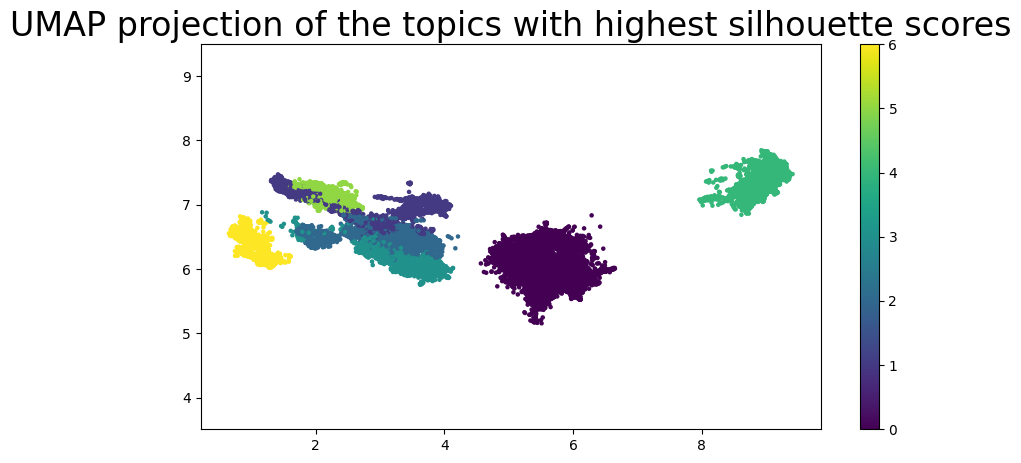

In [115]:
best_indices = np.argsort(silhouette_scores)[-10:]
best_umap_embeddings = umap_embeddings[best_indices]
plt.figure(figsize=(10, 5))
plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='viridis', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()
plt.title('UMAP projection of the topics with highest silhouette scores', fontsize=24)
plt.show()

In [116]:
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 5))
topic_model.update_topics(tc1.corpus, vectorizer_model=vectorizer_model)

In [117]:
topic_model.get_topic_freq()

Topic  Count
0     -1  34815
3      0   7477
4      1   6133
1      2   4908
5      3   4122
2      4   4053
6      5   2238
7      6   1783

In [118]:
print(topic_model.get_topic_info())
for topic_id in set(topics):
    print(f"Topic {topic_id}:")
    print(topic_model.get_topic(topic_id))

   Topic  Count                                         Name  \
0     -1  34815                      -1_vendor_new_free_help   
1      0   7477                       0_weed_vendor_xanax_mg   
2      1   6133                 1_market_empire_dream_vendor   
3      2   4908                2_vendor_scammer_scam_looking   
4      3   4122                         3_mdma_lsd_shit_good   
5      4   4053  4_review_vendor review_vendor_review vendor   
6      5   2238            5_order_package_shipping_delivery   
7      6   1783                 6_card_wallet_bitcoin_credit   

                                      Representation  \
0  [vendor, new, free, help, best, uk, account, n...   
1  [weed, vendor, xanax, mg, cocaine, uk, best, c...   
2  [market, empire, dream, vendor, nightmare, dre...   
3  [vendor, scammer, scam, looking, scamming, exi...   
4  [mdma, lsd, shit, good, got, whats, fuck, goin...   
5  [review, vendor review, vendor, review vendor,...   
6  [order, package, shipping, d

In [119]:
topic_model.visualize_topics()

In [120]:
topic_model.visualize_heatmap()

In [121]:
topic_model.visualize_hierarchy()

In [122]:
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, 
                          min_dist=0.0, metric='cosine').fit_transform(tc1.corpus_embeddings)
topic_model.visualize_documents(tc1.corpus, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True)

In [144]:
new_topics = topic_model.reduce_outliers(tc1.corpus, topics, threshold=0.1, strategy='c-tf-idf')
topic_model.update_topics(tc1.corpus, topics=new_topics)

2024-06-25 22:33:07,995 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [145]:
topic_model.get_topic_info()

Topic  Count                                         Name  \
0     -1  31699                      -1_anyone_new_help_free   
1      0   7793                       0_weed_xanax_mg_vendor   
2      1   6437              1_market_empire_dream_nightmare   
3      2   6395                2_vendor_scammer_scam_looking   
4      3   4125                          3_mdma_lsd_get_shit   
5      4   4230  4_review_vendor review_vendor_review vendor   
6      5   2749            5_order_package_shipping_delivery   
7      6   2101                 6_card_bitcoin_wallet_credit   

                                      Representation  \
0  [anyone, new, help, free, please, need, ticket...   
1  [weed, xanax, mg, vendor, cocaine, uk, best, c...   
2  [market, empire, dream, nightmare, vendor, emp...   
3  [vendor, scammer, scam, looking, vendor vendor...   
4  [mdma, lsd, get, shit, got, good, whats, fuck,...   
5  [review, vendor review, vendor, review vendor,...   
6  [order, package, shipping, delivery, shipped, ...   
7  [card, bitcoin, wallet, credit, carding, btc, ...   

                                 Representative_Docs  
0  [new weed cartridge vendor rapture empire free...  
1  [best uk weed vendor big bulk discount free sh...  
2  [dream market vendor bond, empire market exit ...  
3  [vendor xtc selective scammer, warning scam al...  
4  [holy shit missed guy, whats point ddos people...  
5  [vendor product review, heinekenexpress vendor...  
6  [placed order day ago finally marked shipped m...  
7  [need fullz credit card bank account top dolla...

In [146]:
topic_model.visualize_documents(tc1.corpus, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True)

In [147]:
topic_model.visualize_hierarchy()

In [148]:
topic_model.visualize_topics()

In [156]:
umap_embeddings = topic_model.umap_model.fit_transform(tc1.corpus_embeddings)
indices = [index for index, topic in enumerate(new_topics) if topic != -1]
X=umap_embeddings[np.array(indices)]
labels = [topic for index, topic in enumerate(new_topics) if topic != -1]
silhouette_scores = silhouette_score(X, labels)
print(f"silhouette_score: {silhouette_scores}")
print(f"Davies_bouldin_score: {davies_bouldin_score(X, labels)}")

silhouette_score: 0.5603948831558228
Davies_bouldin_score: 0.7277847294313646


In [157]:
df['name_thread'] = df['name_thread'].str.lower().dropna()
df.drop_duplicates(subset='name_thread', inplace=True)
df.dropna(subset=['name_thread'], inplace=True)
created_on = df['created_on'].tolist()
len(created_on)

65529

In [124]:
topics_over_time = topic_model.topics_over_time(tc1.corpus, created_on, 
                                                global_tuning=True, evolution_tuning=True, nr_bins=300)

25it [04:44, 11.39s/it]


In [131]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[0, 1, 2, 3, 4, 5, 6], width=1250, height=700)

In [158]:
indices = [index for index, topic in enumerate(topics) if topic != -1]
corpus_valid = [tc1.corpus[i] for i in indices]
created_on_valid = [created_on[i] for i in indices]
embeddings_valid = [tc1.corpus_embeddings[i] for i in indices]
topics_valid = [topics[i] for i in indices]
probs_valid = [probs[i] for i in indices]

# Unisci i risultati con le informazioni sui topic
results = pd.DataFrame({
    'Document': corpus_valid,
    'Embedding': embeddings_valid,
    'Topic': topics_valid,
    'Probability': probs_valid
})
results_final = pd.merge(results, topic_model.get_topic_info(), on='Topic')

# Aggiungi le embeddings UMAP al DataFrame results_final
results_final['UMAP_embedding'] = list(X)
print(results_final.shape)
results_final.head()

(33830, 9)


Document  \
0                    drugssupply potential exit scam   
1          karmaking personal store review crosspost   
2  vendor review thebteam dream market sample gra...   
3  ketamine mdma meth ice heroin coke ship austra...   
4                                    diazepam vendor   

                                           Embedding  Topic  Probability  \
0  [0.034511916, -0.0046993867, -0.020613767, -0....      2     0.835194   
1  [-0.043380827, 0.03714014, -0.028550187, 0.010...      4     1.000000   
2  [0.0419851, 0.0065825256, -0.06525973, -0.0043...      4     0.588088   
3  [0.025260657, 0.017700816, 0.0477275, -0.03870...      0     0.955069   
4  [0.03550785, -0.009560079, -0.07405612, 0.0275...      2     1.000000   

   Count                                         Name  \
0   6395                2_vendor_scammer_scam_looking   
1   4230  4_review_vendor review_vendor_review vendor   
2   4230  4_review_vendor review_vendor_review vendor   
3   7793                       0_weed_xanax_mg_vendor   
4   6395                2_vendor_scammer_scam_looking   

                                      Representation  \
0  [vendor, scammer, scam, looking, vendor vendor...   
1  [review, vendor review, vendor, review vendor,...   
2  [review, vendor review, vendor, review vendor,...   
3  [weed, xanax, mg, vendor, cocaine, uk, best, c...   
4  [vendor, scammer, scam, looking, vendor vendor...   

                                 Representative_Docs  \
0  [vendor xtc selective scammer, warning scam al...   
1  [vendor product review, heinekenexpress vendor...   
2  [vendor product review, heinekenexpress vendor...   
3  [best uk weed vendor big bulk discount free sh...   
4  [vendor xtc selective scammer, warning scam al...   

                                      UMAP_embedding  
0  [0.39825505, 1.9966363, 6.5130215, 10.321705, ...  
1  [-0.07015347, 8.904426, 7.5405426, 9.217339, 2...  
2  [0.00010026313, 8.4563875, 7.132244, 9.648071,...  
3  [-0.025930932, 5.9145336, 6.3106866, 10.26776,...  
4  [0.19230145, 3.402927, 6.4148946, 9.966687, 1....

In [127]:
topic_model.save("topic_model_0.64Sil", serialization='pickle')

2024-06-25 22:26:41,979 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [159]:
results_final.to_parquet('Results_BERTopic/BERTopic_nodefinedcluster_topics_15n_10com_1200cluster_0.64sil_renewout.parquet')

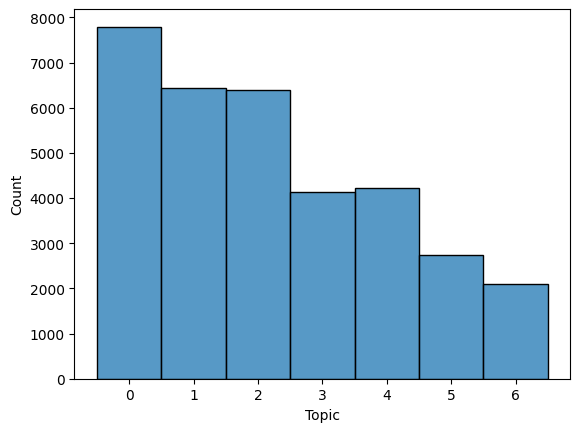

In [160]:
sns.histplot(results_final, x='Topic', discrete=True);

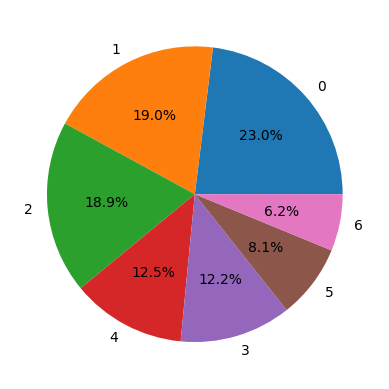

In [161]:
plt.pie(results_final.value_counts('Topic'), labels=results_final.value_counts('Topic').index, autopct='%1.1f%%');

In [ ]:
indices = [index for index, topic in enumerate(new_topics) if topic != -1]
corpus_valid = [tc1.corpus[i] for i in indices]
created_on_valid = [created_on[i] for i in indices]
embeddings_valid = [tc1.corpus_embeddings[i] for i in indices]
topics_valid = [new_topics[i] for i in indices]
probs_valid = [probs[i] for i in indices]

# Unisci i risultati con le informazioni sui topic
results = pd.DataFrame({
    'Document': corpus_valid,
    'Embedding': embeddings_valid,
    'Topic': topics_valid,
    'Probability': probs_valid
})
results_final = pd.merge(results, topic_model.get_topic_info(), on='Topic')

# Aggiungi le embeddings UMAP al DataFrame results_final
results_final['UMAP_embedding'] = list(X)
print(results_final.shape)
results_final.head()